In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
#pd.set_option('display.max_rows', None)

from tqdm import tqdm, tqdm_notebook

from glob import glob
import gc

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import plotly.express as px #Plotly Express

from plotly.offline import iplot
#to link plotly to pandas
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline = False, world_readable = True)

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['axes.titlesize'] = 16
plt.style.use('seaborn-whitegrid')
sns.set_palette('Set3')

import os
print(os.listdir('../input/secondhand-apartment-price-forecasting-2021/'))

import warnings
warnings.simplefilter('ignore')

from time import time, strftime, gmtime
start = time()
import datetime
print(str(datetime.datetime.now()))

['18.csv', '20.csv', '42.csv', '33.csv', 'sample_submission.csv', '07.csv', '24.csv', '11.csv', '30.csv', '17.csv', '36.csv', '16.csv', '38.csv', '31.csv', '19.csv', '35.csv', '41.csv', '45.csv', '26.csv', '28.csv', '13.csv', '43.csv', '23.csv', '14.csv', '22.csv', '40.csv', '44.csv', '06.csv', '05.csv', '12.csv', '39.csv', '09.csv', 'data_explanation.xlsx', '04.csv', '01.csv', '47.csv', '03.csv', '15.csv', '37.csv', '10.csv', '08.csv', '25.csv', '29.csv', 'test.csv', '21.csv', '32.csv', '34.csv', '27.csv', '02.csv', '46.csv']
2021-04-11 07:37:38.999081


In [2]:
train_column_names = ['ID', 'Type', 'Region', 'City Code', 'Prefecture Name', 'City Name', 'District Name', 
                'Nearest Station: Name', "Nearest station: Distance (minutes)", "Floor plan", "Area (㎡)", 
                "Land shape", "Frontage", "Total floor area (㎡)", "Building year", "Building structure", "Use", 
                "Purpose of future use", "Front road: Direction", "Front road: Type", "Front road: Width (m)", 
                "City planning", "Building coverage ratio (%)", 'Floor area ratio (%)',
                'At the time of transaction', 'Refurbishment', 'Transaction circumstances, etc.', 
                      'Transaction price (total amount) _log']

test_column_names = ['ID', 'Type', 'Region', 'City Code', 'Prefecture Name', 'City Name', 'District Name', 
                'Nearest Station: Name', "Nearest station: Distance (minutes)", "Floor plan", "Area (㎡)", 
                "Land shape", "Frontage", "Total floor area (㎡)", "Building year", "Building structure", "Use", 
                "Purpose of future use", "Front road: Direction", "Front road: Type", "Front road: Width (m)", 
                "City planning", "Building coverage ratio (%)", 'Floor area ratio (%)',
                'At the time of transaction', 'Refurbishment', 'Transaction circumstances, etc.']

In [3]:
base_dir = '../input/secondhand-apartment-price-forecasting-2021/'

In [4]:
test = pd.read_csv(base_dir + 'test.csv')
print(test.shape)
test.columns = test_column_names
test.head()

(17894, 27)


,ID,Type,Region,City Code,Prefecture Name,City Name,District Name,Nearest Station: Name,Nearest station: Distance (minutes),Floor plan,Area (㎡),Land shape,Frontage,Total floor area (㎡),Building year,Building structure,Use,Purpose of future use,Front road: Direction,Front road: Type,Front road: Width (m),City planning,Building coverage ratio (%),Floor area ratio (%),At the time of transaction,Refurbishment,"Transaction circumstances, etc."
0,1000000,中古マンション等,NaN,1101,北海道,札幌市中央区,旭ケ丘,円山公園,26,３ＬＤＫ,75,NaN,NaN,NaN,昭和64年,ＲＣ,NaN,住宅,NaN,NaN,NaN,第１種低層住居専用地域,40.0,60.0,2020年第２四半期,未改装,NaN
1,1000110,中古マンション等,NaN,1101,北海道,札幌市中央区,大通西,西１８丁目,2,１ＬＤＫ,45,NaN,NaN,NaN,平成3年,ＳＲＣ,住宅,その他,NaN,NaN,NaN,商業地域,80.0,400.0,2020年第３四半期,未改装,NaN
2,1000111,中古マンション等,NaN,1101,北海道,札幌市中央区,大通西,西１８丁目,2,２ＬＤＫ,50,NaN,NaN,NaN,昭和64年,ＳＲＣ,住宅,住宅,NaN,NaN,NaN,商業地域,80.0,400.0,2020年第３四半期,改装済,NaN
3,1000112,中古マンション等,NaN,1101,北海道,札幌市中央区,大通西,西１８丁目,3,２ＬＤＫ,80,NaN,NaN,NaN,平成9年,ＲＣ,NaN,住宅,NaN,NaN,NaN,商業地域,80.0,400.0,2020年第３四半期,改装済,NaN
4,1000113,中古マンション等,NaN,1101,北海道,札幌市中央区,大通西,西１８丁目,3,１Ｋ,20,NaN,NaN,NaN,昭和56年,ＲＣ,NaN,住宅,NaN,NaN,NaN,商業地域,80.0,400.0,2020年第３四半期,未改装,NaN


In [5]:
sub = pd.read_csv(base_dir + 'sample_submission.csv')
sub

,ID,取引価格（総額）_log
0,1000000,0
1,1000110,0
2,1000111,0
3,1000112,0
4,1000113,0
...,...,...
17889,47006180,0
17890,47006652,0
17891,47006790,0
17892,47007026,0


__Combine train dataframes into a single train dataframe__

In [6]:
train = pd.DataFrame()
for path in tqdm_notebook(glob(base_dir + '[0-9][0-9].csv')):
    temp = pd.read_csv(path)
    train = train.append(temp, ignore_index = True)
train.columns = train_column_names
print(train.shape)
train.head()

  0%|          | 0/47 [00:00<?, ?it/s]

(651975, 28)


,ID,Type,Region,City Code,Prefecture Name,City Name,District Name,Nearest Station: Name,Nearest station: Distance (minutes),Floor plan,Area (㎡),Land shape,Frontage,Total floor area (㎡),Building year,Building structure,Use,Purpose of future use,Front road: Direction,Front road: Type,Front road: Width (m),City planning,Building coverage ratio (%),Floor area ratio (%),At the time of transaction,Refurbishment,"Transaction circumstances, etc.",Transaction price (total amount) _log
0,18016956,中古マンション等,NaN,18201,福井県,福井市,大宮,田原町(福井),13,４ＬＤＫ,80,NaN,NaN,NaN,平成13年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種中高層住居専用地域,60.0,200.0,2013年第１四半期,改装済,NaN,7.204120
1,18017527,中古マンション等,NaN,18201,福井県,福井市,中央,福井(福井),4,１ＬＤＫ,60,NaN,NaN,NaN,平成22年,ＳＲＣ,住宅,NaN,NaN,NaN,NaN,商業地域,80.0,600.0,2013年第１四半期,未改装,NaN,7.255273
2,18019565,中古マンション等,NaN,18201,福井県,福井市,文京,福大前西福井,5,１Ｋ,15,NaN,NaN,NaN,平成5年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種住居地域,60.0,200.0,2009年第３四半期,未改装,NaN,6.176091
3,18011653,中古マンション等,NaN,18201,福井県,福井市,開発,越前開発,13,３ＬＤＫ,95,NaN,NaN,NaN,NaN,ＲＣ,住宅,NaN,NaN,NaN,NaN,準工業地域,60.0,200.0,2011年第４四半期,未改装,NaN,7.505150
4,18021274,中古マンション等,NaN,18201,福井県,福井市,城東,福井(福井),18,３ＬＤＫ,65,NaN,NaN,NaN,平成9年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種中高層住居専用地域,60.0,200.0,2007年第２四半期,改装済,NaN,7.113943


In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,651975.0,1.847844e+07,9.568488e+06,1.000008e+06,13062658.5,1.402969e+07,2.703359e+07,4.703278e+07
Region,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City Code,651975.0,1.851426e+04,9.594814e+03,1.101000e+03,13107.0,1.410400e+04,2.711400e+04,4.721300e+04
Land shape,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Frontage,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total floor area (㎡),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Front road: Direction,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Front road: Type,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Front road: Width (m),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Building coverage ratio (%),629168.0,6.761703e+01,1.040410e+01,3.000000e+01,60.0,6.000000e+01,8.000000e+01,8.000000e+01


In [8]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651975 entries, 0 to 651974
Data columns (total 28 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   ID                                     651975 non-null  int64  
 1   Type                                   651975 non-null  object 
 2   Region                                 0 non-null       float64
 3   City Code                              651975 non-null  int64  
 4   Prefecture Name                        651975 non-null  object 
 5   City Name                              651975 non-null  object 
 6   District Name                          651318 non-null  object 
 7   Nearest Station: Name                  649342 non-null  object 
 8   Nearest station: Distance (minutes)    628916 non-null  object 
 9   Floor plan                             629546 non-null  object 
 10  Area (㎡)                               651975 non-null  

(None, None)

In [9]:
missing = train.isna().sum().reset_index()
missing.columns = ['features', 'total_missing']
missing['percent'] = (missing['total_missing'] / len(train)) * 100
missing.index = missing['features']
del missing['features']

missing['total_missing'].iplot(kind = 'bar', 
                               title = 'Missing Values Plot in Trainset',
                               xTitle = 'Features',
                               yTitle = 'Count')
missing.T

features,ID,Type,Region,City Code,Prefecture Name,City Name,District Name,Nearest Station: Name,Nearest station: Distance (minutes),Floor plan,Area (㎡),Land shape,Frontage,Total floor area (㎡),Building year,Building structure,Use,Purpose of future use,Front road: Direction,Front road: Type,Front road: Width (m),City planning,Building coverage ratio (%),Floor area ratio (%),At the time of transaction,Refurbishment,"Transaction circumstances, etc.",Transaction price (total amount) _log
total_missing,0.0,0.0,651975.0,0.0,0.0,0.0,657.000000,2633.00000,23059.000000,22429.000000,0.0,651975.0,651975.0,651975.0,18695.000000,14877.000000,50642.000000,363027.000000,651975.0,651975.0,651975.0,18813.00000,22807.00000,22807.00000,0.0,58674.000000,633578.000000,0.0
percent,0.0,0.0,100.0,0.0,0.0,0.0,0.100771,0.40385,3.536792,3.440163,0.0,100.0,100.0,100.0,2.867441,2.281836,7.767476,55.681123,100.0,100.0,100.0,2.88554,3.49814,3.49814,0.0,8.999425,97.178266,0.0


In [10]:
test_missing = test.isna().sum().reset_index()
test_missing.columns = ['features', 'total_missing']
test_missing['percent'] = (test_missing['total_missing'] / len(train)) * 100
test_missing.index = test_missing['features']
del test_missing['features']

test_missing['total_missing'].iplot(kind = 'bar', 
                               title = 'Missing Values Plot in Testset',
                               xTitle = 'Features',
                               yTitle = 'Count')
test_missing.T

features,ID,Type,Region,City Code,Prefecture Name,City Name,District Name,Nearest Station: Name,Nearest station: Distance (minutes),Floor plan,Area (㎡),Land shape,Frontage,Total floor area (㎡),Building year,Building structure,Use,Purpose of future use,Front road: Direction,Front road: Type,Front road: Width (m),City planning,Building coverage ratio (%),Floor area ratio (%),At the time of transaction,Refurbishment,"Transaction circumstances, etc."
total_missing,0.0,0.0,17894.000000,0.0,0.0,0.0,3.00000,23.000000,23.000000,812.000000,0.0,17894.000000,17894.000000,17894.000000,607.000000,1118.000000,5370.000000,795.000000,17894.000000,17894.000000,17894.000000,277.000000,365.000000,365.000000,0.0,2267.000000,17801.000000
percent,0.0,0.0,2.744584,0.0,0.0,0.0,0.00046,0.003528,0.003528,0.124545,0.0,2.744584,2.744584,2.744584,0.093102,0.171479,0.823651,0.121937,2.744584,2.744584,2.744584,0.042486,0.055984,0.055984,0.0,0.347713,2.730319


In [11]:
drop_cols = missing[missing['percent'] > 95].index.tolist()
print(f"Number of features to drop: {len(drop_cols)}")
train.drop(drop_cols, axis = 1, inplace = True)
test.drop(drop_cols, axis = 1, inplace = True)
train.shape, test.shape

Number of features to drop: 8


((651975, 20), (17894, 19))

- We should drop 'Type' as well as Type has only one value in train

In [12]:
train.drop('Type', axis = 1, inplace = True)
test.drop('Type', axis = 1, inplace = True)
train.shape, test.shape

((651975, 19), (17894, 18))

In [13]:
del missing, test_missing
gc.collect()

1763

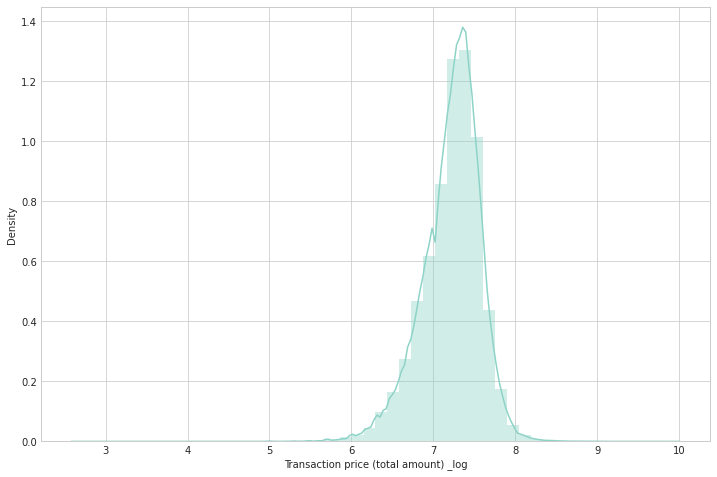

In [14]:
sns.distplot(train['Transaction price (total amount) _log']);

In [15]:
train['Floor plan'].value_counts().sort_values(ascending = True).iplot(kind = 'bar', 
                                                                  orientation = 'h',
                                                                  yTitle = 'Floors',
                                                                  title = 'Countplot of Apartment Floor'
                                                                 )

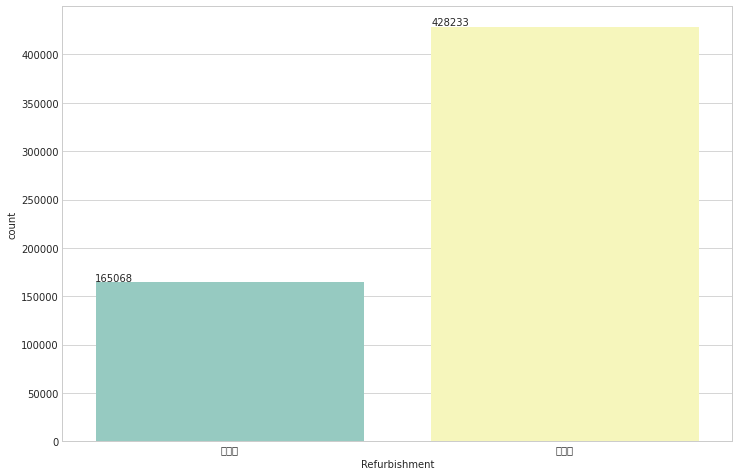

In [16]:
ax = sns.countplot(data = train, x = 'Refurbishment')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

__Cleaning the Data__

In [17]:
train['Area (㎡)'].unique()

array([80, 60, 15, 95, 65, 45, 75, 20, 25, 85, 50, 35, 30, 55, 105, 110,
       70, 90, 125, 100, 165, 135, 130, 40, 120, 115, 140, 180, 150, 155,
       370, 230, '65', '75', '85', '95', '80', '70', '60', '100', '90',
       '50', '20', '55', '40', '105', '45', '980', '35', '115', '120',
       '270', '110', '30', '290', '150', '820', '470', '300', '830', '25',
       '125', '160', '140', '710', '130', '15', '2000㎡以上', '165', 550,
       160, 145, 10, 350, 190, 290, 360, 200, 490, 420, 240, 170, 320,
       330, 195, 860, 220, 1000, 460, 175, 270, 210, 580, 260, 185, 280,
       '10', '155', '185', '145', '780', '590', '135', '320', '650',
       '190', '250', '410', '630', '620', '170', '660', '200', '510',
       '180', '730', '360', '195', '175', '240', '390', '220', '490',
       '370', '520', '1400', '670', '310', '560', '210', '760', '450',
       '900', 250, 340, 300, 500, 400, 630, 440, 1500, 450, 380, 560, 970,
       480, 710, 310, 410, 690, 430, 820, 990, 1200, 390, 590, 68

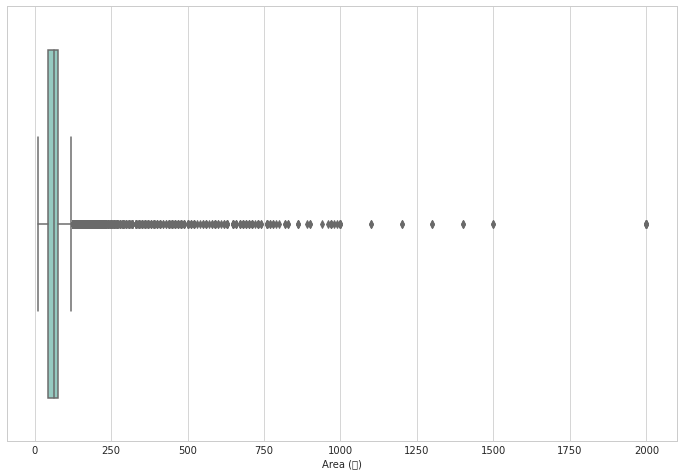

In [18]:
import re

train['Area (㎡)'] = train['Area (㎡)'].apply(lambda x: re.sub(r'\D+', '', str(x)))
test['Area (㎡)'] = test['Area (㎡)'].apply(lambda x: re.sub(r'\D+', '', str(x)))

train['Area (㎡)'] = train['Area (㎡)'].astype('int32')
test['Area (㎡)'] = test['Area (㎡)'].astype('int32')

sns.boxplot(data = train, x = 'Area (㎡)');

In [19]:
train.head(1)

,ID,City Code,Prefecture Name,City Name,District Name,Nearest Station: Name,Nearest station: Distance (minutes),Floor plan,Area (㎡),Building year,Building structure,Use,Purpose of future use,City planning,Building coverage ratio (%),Floor area ratio (%),At the time of transaction,Refurbishment,Transaction price (total amount) _log
0,18016956,18201,福井県,福井市,大宮,田原町(福井),13,４ＬＤＫ,80,平成13年,ＲＣ,住宅,NaN,第１種中高層住居専用地域,60.0,200.0,2013年第１四半期,改装済,7.20412


Text(0.5, 1.0, 'Area vs Transaction Price')

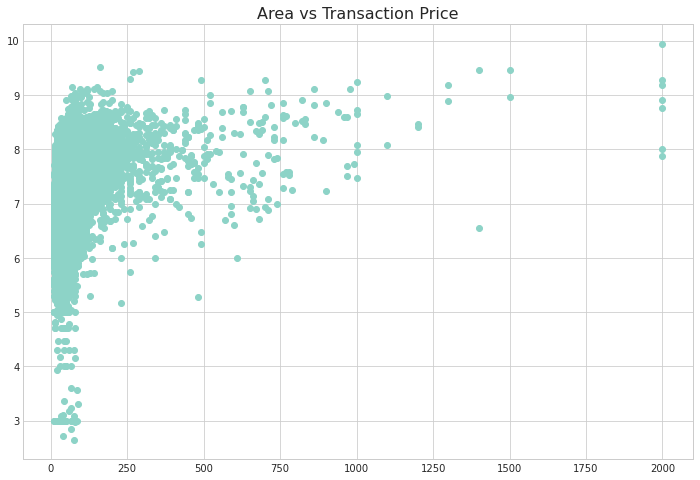

In [20]:
plt.scatter(data = train, x = 'Area (㎡)', y = 'Transaction price (total amount) _log');
plt.title('Area vs Transaction Price')

- LDK is Living, Dining and Kitchen
- 1 LDK means 1 Bedrooms with Living, Dining rooms and Kitchen
- S is Storage room

In [21]:
train['Floor plan'].unique()

array(['４ＬＤＫ', '１ＬＤＫ', '１Ｋ', '３ＬＤＫ', '２ＬＤＫ', nan, '１Ｒ', '１ＤＫ', '２ＤＫ',
       '１ＬＤＫ＋Ｓ', '３ＤＫ', '５ＬＤＫ', 'オープンフロア', '２ＬＤＫ＋Ｓ', '５ＬＤＫ＋Ｓ', '４ＤＫ',
       '２ＤＫ＋Ｓ', '２Ｋ', '３ＬＫ', '３Ｋ', '３ＬＤＫ＋Ｓ', '４ＬＤＫ＋Ｓ', '３ＤＫ＋Ｓ', '３Ｋ＋Ｓ',
       '５ＤＫ', '２ＬＫ', '４Ｋ', '６ＬＤＫ', '４ＤＫ＋Ｓ', 'メゾネット', '１Ｒ＋Ｓ', '１ＤＫ＋Ｓ',
       '２ＬＫ＋Ｓ', '３ＬＤ', '４ＬＤＫ＋Ｋ', '２ＬＤ＋Ｓ', '７ＬＤＫ', '１ＬＫ', '５Ｋ', '１Ｋ＋Ｓ',
       '２Ｌ＋Ｓ', '７ＬＤＫ＋Ｓ', '４Ｌ＋Ｋ', '１Ｌ', 'スタジオ', '３ＬＤＫ＋Ｋ', '２Ｋ＋Ｓ', '６ＤＫ',
       '２ＬＤ', '３ＬＤ＋Ｓ', '１ＬＤ＋Ｓ', '６ＬＤＫ＋Ｓ', '１Ｌ＋Ｓ', '２Ｄ', '８ＬＤＫ', '２Ｌ',
       '２ＬＤＫ＋Ｋ', '５ＬＤＫ＋Ｋ', '３Ｄ', '４Ｄ', '１ＤＫ＋Ｋ', '８ＬＤＫ＋Ｓ', '４Ｌ', '７ＤＫ'],
      dtype=object)

In [22]:
train['num_bedrooms'] = train['Floor plan'].apply(lambda x: str(x)[0])
train['num_bedrooms'] = train['num_bedrooms'].apply(lambda x: int(x) if x.isdigit() else np.nan)
train['num_bedrooms'].fillna(train['num_bedrooms'].median(), inplace = True)

test['num_bedrooms'] = test['Floor plan'].apply(lambda x: str(x)[0])
test['num_bedrooms'] = test['num_bedrooms'].apply(lambda x: int(x) if x.isdigit() else np.nan)
test['num_bedrooms'].fillna(test['num_bedrooms'].median(), inplace = True)
train['num_bedrooms'].value_counts(dropna = False), test['num_bedrooms'].value_counts(dropna = False)

(3.0    319775
 1.0    149247
 2.0    120108
 4.0     61818
 5.0       973
 6.0        43
 7.0         8
 8.0         3
 Name: num_bedrooms, dtype: int64,
 3.0    8202
 1.0    4760
 2.0    3458
 4.0    1446
 5.0      26
 6.0       2
 Name: num_bedrooms, dtype: int64)

train['living'] = train['Floor plan'].apply(lambda x: 1 if 'L' in str(x) else 0) 
train['dining'] = train['Floor plan'].apply(lambda x: 1 if 'D' in str(x) else 0) 
train['kitchen'] = train['Floor plan'].apply(lambda x: 1 if 'K' in str(x) else 0) 
train['storage'] = train['Floor plan'].apply(lambda x: 1 if 'S' in str(x) else 0)

test['living'] = test['Floor plan'].apply(lambda x: 1 if 'L' in str(x) else 0) 
test['dining'] = test['Floor plan'].apply(lambda x: 1 if 'D' in str(x) else 0) 
test['kitchen'] = test['Floor plan'].apply(lambda x: 1 if 'K' in str(x) else 0) 
test['storage'] = test['Floor plan'].apply(lambda x: 1 if 'S' in str(x) else 0)

train['living'].unique()

In [23]:
categorical_features = [c for c in train.columns if train[c].dtype == 'object']
numerical_features = [c for c in train.columns if c not in categorical_features]
numerical_features, categorical_features, len(numerical_features), len(categorical_features)

(['ID',
  'City Code',
  'Area (㎡)',
  'Building coverage ratio (%)',
  'Floor area ratio (%)',
  'Transaction price (total amount) _log',
  'num_bedrooms'],
 ['Prefecture Name',
  'City Name',
  'District Name',
  'Nearest Station: Name',
  'Nearest station: Distance (minutes)',
  'Floor plan',
  'Building year',
  'Building structure',
  'Use',
  'Purpose of future use',
  'City planning',
  'At the time of transaction',
  'Refurbishment'],
 7,
 13)

In [24]:
df = train.sample(100000)
df.shape

(100000, 20)

In [25]:
corr = df[numerical_features].corr()
print(corr['Transaction price (total amount) _log'].sort_values(ascending = False))

Transaction price (total amount) _log    1.000000
Area (㎡)                                 0.392924
num_bedrooms                             0.201113
Floor area ratio (%)                     0.106336
Building coverage ratio (%)              0.019258
ID                                      -0.154264
City Code                               -0.155475
Name: Transaction price (total amount) _log, dtype: float64


In [26]:
missing = train.isna().sum().reset_index()
missing['dtype'] = [train[c].dtype for c in missing['index']]
missing = missing[missing[0] > 0]
missing

,index,0,dtype
4,District Name,657,object
5,Nearest Station: Name,2633,object
6,Nearest station: Distance (minutes),23059,object
7,Floor plan,22429,object
9,Building year,18695,object
10,Building structure,14877,object
11,Use,50642,object
12,Purpose of future use,363027,object
13,City planning,18813,object
14,Building coverage ratio (%),22807,float64


In [27]:
print('Imputing NaNs of object dtype by most occurances')
for c in missing['index'][missing['dtype'] == 'object']:
    train[c] = train[c].fillna(train[c].value_counts().index[0])
    test[c] = test[c].fillna(train[c].value_counts().index[0])
    
print('Imputing NaNs of float dtype by mean value')
for c in missing['index'][missing['dtype'] == 'float64']:
    train[c] = train[c].fillna(train[c].mean())
    test[c] = test[c].fillna(test[c].mean())

Imputing NaNs of object dtype by most occurances
Imputing NaNs of float dtype by mean value


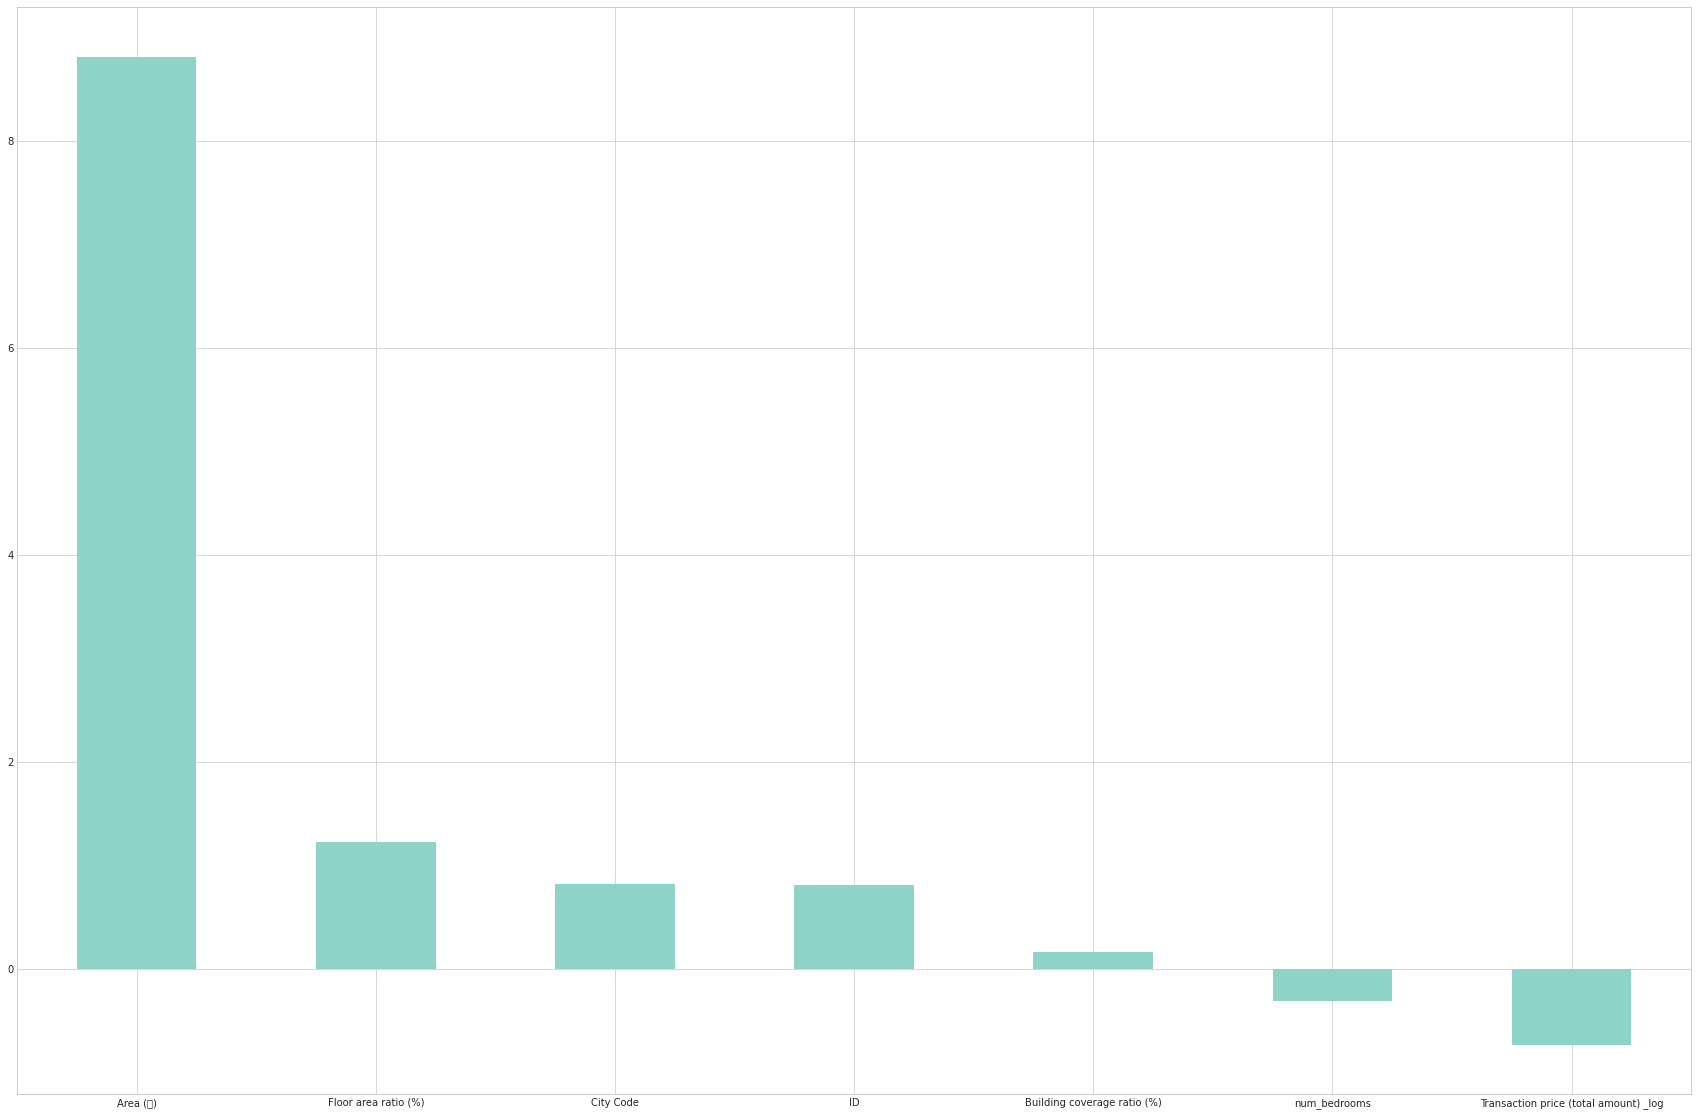

In [28]:
from scipy.stats import skew

num_feats = train.dtypes[train.dtypes != 'object'].index

# Check how skewed they are
skewed_feats = train[num_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)

plt.subplots(figsize = (30, 20))
skewed_feats.plot(kind = 'bar', rot = 0);

__Standardize Numerical Features and Label Encode Categorical Features__

In [29]:
numerical_features.remove('ID')
numerical_features.remove('Transaction price (total amount) _log')
train.drop(['ID'], axis = 1, inplace = True)
test.drop(['ID'], axis = 1, inplace = True)

In [30]:
scl = StandardScaler()
train[numerical_features] = scl.fit_transform(train[numerical_features])
test[numerical_features] = scl.transform(test[numerical_features])

In [31]:
lbl = LabelEncoder()
for c in categorical_features:
    lbl.fit(list(train[c].astype(str).values) + list(test[c].astype(str).values))
    train[c] = lbl.transform(list(train[c].astype(str).values))
    test[c] = lbl.transform(list(test[c].astype(str).values))
print('Label Encoding Categorical Features done..')

Label Encoding Categorical Features done..


- Check if the most recurrent value of the feature is repeated almost in all the instances. If it does then it drops these features because their values are almost the same for all instances and will not help in the learning process.

In [32]:
repeated = []
for c in df.columns:
    counts = df[c].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(df) * 100 > 99.94:
        repeated.append(c)
repeated = list(repeated)
if repeated:
    print(f"These are the features with same repeated value: {repeated}")
    train = train.drop(repeated, axis = 1)
    test = test.drop(repeated, axis = 1)
else:
    print('No repeated values in columns')

No repeated values in columns


In [33]:
target = train['Transaction price (total amount) _log'].copy()
train.drop(['Transaction price (total amount) _log'], axis = 1, inplace = True)

In [34]:
Xtrain, Xvalid, ytrain, yvalid = train_test_split(train, target, test_size = 0.2, random_state = 2021)
print(Xtrain.shape, ytrain.shape, Xvalid.shape, yvalid.shape)

(521580, 18) (521580,) (130395, 18) (130395,)


In [35]:
from sklearn.metrics import mean_absolute_error

In [36]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(
               objective = 'regression', 
               num_leaves = 4,
               learning_rate = 0.01, 
               n_estimators = 10000,
               max_bin = 200, 
               bagging_fraction = 0.75,
               bagging_freq = 5, 
               bagging_seed = 7,
               feature_fraction = 0.2,
               feature_fraction_seed = 7,
               verbose = 1,
            )

lgbm_model = lgbm.fit(Xtrain, ytrain)
lg_vpreds = lgbm_model.predict(Xvalid)
print((f"LGBM MAE: {mean_absolute_error(yvalid, lg_vpreds)}"))

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


LightGBMError: Do not support special JSON characters in feature name.

In [37]:
lg_preds = lgbm_model.predict(test)
sub['取引価格（総額）_log'] = lg_preds
sub.to_csv('sub_lgbm.csv', index = False)
sub.head()

NameError: name 'lgbm_model' is not defined

In [38]:
finish = time()
print(strftime("%H:%M:%S", gmtime(finish - start)))

00:01:02
